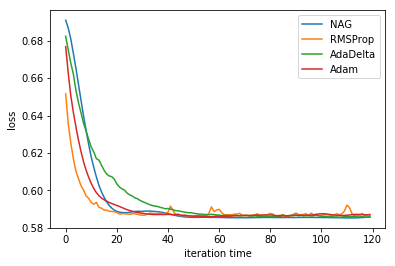

In [1]:
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import numpy as np
import math as mt
import random as rand


def random_sample(x, y):
    long = 64
    samples_index = rand.sample(range(0, x.shape[0]), long)
    x_samples = np.ones((0, x.shape[1]))
    y_samples = np.ones((0, y.shape[1]))
    
    for i in samples_index:
        x_samples = np.r_[x_samples, x[i].reshape(1, x.shape[1])]
        y_samples = np.r_[y_samples, y[i].reshape(1, y.shape[1])]
    
    return x_samples, y_samples
    

def NAG(x, y, params):
    x_sample, y_sample = random_sample(x, y)
    W_ = params['W'] - params['alpha'] * params['v']
    g = np.zeros(W_.shape)
    for i in range(0, x_sample.shape[0]):
        Xi = x_sample[i].reshape(1, x_sample.shape[1]).T
        g = g + y_sample[i] * Xi / (1 + mt.exp(y_sample[i] * np.dot(W_.T, Xi)))
        
    g = params['lambda'] * W_ - g / x_sample.shape[0]
    params['v'] = params['alpha'] * params['v'] - params['learning_rate'] * g
    params['W'] = params['W'] + params['v']
    
    return params


def RMSProp(x, y, params):
    x_sample, y_sample = random_sample(x, y)
    g = np.zeros(params['W'].shape)
    for i in range(0, x_sample.shape[0]):
        Xi = x_sample[i].reshape(1, x_sample.shape[1]).T
        g = g + y_sample[i] * Xi / (1 + mt.exp(y_sample[i] * np.dot(params['W'].T, Xi)))
    
    g = params['lambda'] * params['W'] - g / x_sample.shape[0]
    params['r'] = params['rho'] * params['r'] + (1 - params['rho']) * (g * g)
    params['W'] = params['W'] - (params['learning_rate'] / np.sqrt(params['r'] + params['delta'])) * g
    
    
    return params


def AdaDelta(x, y, params):
    x_sample, y_sample = random_sample(x, y)
    g = np.zeros(params['W'].shape)
    for i in range(0, x_sample.shape[0]):
        Xi = x_sample[i].reshape(1, x_sample.shape[1]).T
        g = g + y_sample[i] * Xi / (1 + mt.exp(y_sample[i] * np.dot(params['W'].T, Xi)))
    
    g = params['lambda'] * params['W'] - g / x_sample.shape[0]
    
    params['E'] = params['gamma'] * params['E'] + (1 - params['gamma']) * (g * g)
    delta_t =  -(np.sqrt(params['E_'] + params['delta']) / np.sqrt(params['E'] + params['delta'])) * g
    params['E_'] = params['gamma'] * params['E_'] + (1 - params['gamma']) * (delta_t * delta_t)
    params['W'] = params['W'] + delta_t
    
    return params


def Adam(x, y, params):
    x_sample, y_sample = random_sample(x, y)
    g = np.zeros(params['W'].shape)
    for i in range(0, x_sample.shape[0]):
        Xi = x_sample[i].reshape(1, x_sample.shape[1]).T
        g = g + y_sample[i] * Xi / (1 + mt.exp(y_sample[i] * np.dot(params['W'].T, Xi)))
    
    g = params['lambda'] * params['W'] - g / x_sample.shape[0]
    params['t'] += 1
    params['s'] = params['rho1'] * params['s'] + (1 - params['rho1']) * g
    params['r'] = params['rho2'] * params['r'] + (1 - params['rho2']) * (g * g)
    s_ = params['s'] / (1 - params['rho1']**params['t'])
    r_ = params['r'] / (1 - params['rho2']**params['t'])
    params['W'] = params['W'] - params['learning_rate'] * s_ / (np.sqrt(r_) + params['delta'])
    
    return params


def judge(x, y, threshold, params):
    count = 0
    y_pre = np.zeros(y.shape)
    y_pre = np.dot(x, params['W'])
    for i in range(0, x.shape[0]):
        if y_pre[i] >= threshold:
            y_pre[i] = 1
        else:
            y_pre[i] = -1
        
        if y_pre[i] == y[i]:
            count += 1
            
    return count / x.shape[0]


X_train,y_train = load_svmlight_file("a9a")
X_test,y_test = load_svmlight_file("a9a.t", n_features = 123)

X_train = X_train.toarray()
X_test = X_test.toarray()

y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

params_NAG = {
    'learning_rate': 0.005,
    'v': np.zeros((X_train.shape[1], 1)),
    'W': np.zeros((X_train.shape[1], 1)),
    'alpha': 0.9,
    'lambda': 0.9,
    'iteration_time': 120
}

params_RMS = {
    'learning_rate': 0.005,
    'lambda': 0.9,
    'iteration_time': 120,
    'delta': 1e-6,
    'rho': 0.9,
    'r': np.zeros((X_train.shape[1], 1)),
    'W': np.zeros((X_train.shape[1], 1))
}

params_AdaDelta = {
    'learning_rate': 0.005,
    'lambda': 0.9,
    'iteration_time': 120,
    'delta': 1e-6,
    'gamma': 0.9,
    'E': np.zeros((X_train.shape[1], 1)),
    'E_': np.zeros((X_train.shape[1], 1)),
    'W': np.zeros((X_train.shape[1], 1))
}

params_Adam = {
    'learning_rate': 0.005,
    'lambda': 0.9,
    'iteration_time': 120,
    'rho1': 0.9,
    'rho2': 0.999,
    'delta': 1e-8,
    't': 0,
    's': np.zeros((X_train.shape[1], 1)),
    'r': np.zeros((X_train.shape[1], 1)),
    'W': np.zeros((X_train.shape[1], 1))
}

threshold_nag = -0.5
threshold_rms = -0.5
threshold_adad = -0.5
threshold_adam = -0.4
L_nag = np.zeros((params_NAG['iteration_time']))
L_rms = np.zeros((params_RMS['iteration_time']))
L_adad = np.zeros((params_AdaDelta['iteration_time']))
L_adam = np.zeros((params_Adam['iteration_time']))

for i in range(0, params_NAG['iteration_time']):
    params_NAG = NAG(X_train, y_train, params_NAG)
    params_RMS = RMSProp(X_train, y_train, params_RMS)
    params_AdaDelta = AdaDelta(X_train, y_train, params_AdaDelta)
    params_Adam = Adam(X_train, y_train, params_Adam)
    s_nag = 0
    s_rms = 0
    s_adad = 0
    s_adam = 0
    for j in range(0, X_test.shape[0]):
         s_nag += mt.log(1 + mt.exp(-y_test[j] * np.dot(params_NAG['W'].T, X_test[j].T)))
         s_rms += mt.log(1 + mt.exp(-y_test[j] * np.dot(params_RMS['W'].T, X_test[j].T)))
         s_adad += mt.log(1 + mt.exp(-y_test[j] * np.dot(params_AdaDelta['W'].T, X_test[j].T)))
         s_adam += mt.log(1 + mt.exp(-y_test[j] * np.dot(params_Adam['W'].T, X_test[j].T)))
        
    L_nag[i] = s_nag / X_test.shape[0] + np.dot(params_NAG['W'].T, params_NAG['W'])[0][0] * params_NAG['lambda'] / 2 
    L_rms[i] = s_rms / X_test.shape[0] + np.dot(params_RMS['W'].T, params_RMS['W'])[0][0] * params_RMS['lambda'] / 2 
    L_adad[i] = s_adad / X_test.shape[0] + np.dot(params_AdaDelta['W'].T, params_AdaDelta['W'])[0][0] * params_AdaDelta['lambda'] / 2 
    L_adam[i] = s_adam / X_test.shape[0] + np.dot(params_Adam['W'].T, params_Adam['W'])[0][0] * params_Adam['lambda'] / 2 

rate_nag = judge(X_test, y_test, threshold_nag, params_NAG)
rate_rms = judge(X_test, y_test, threshold_rms, params_RMS)
rate_adad = judge(X_test, y_test, threshold_adad, params_AdaDelta)
rate_adam = judge(X_test, y_test, threshold_adam, params_Adam)


plt.plot(L_nag, label = 'NAG')
plt.plot(L_rms, label = 'RMSProp')
plt.plot(L_adad, label = 'AdaDelta')
plt.plot(L_adam, label = 'Adam')
plt.xlabel('iteration time')
plt.ylabel('loss')
plt.legend()
plt.show()